# 2022-01-24 Newton methods

* Office hours: Monday 9-10pm, Tuesday 2-3pm, Thursday 2-3pm
* This week will stay virtual. Plan is to start in-person the following Monday (Jan 31)

## Last time

* Forward and backward error
* Computing volume of a polygon
* Rootfinding examples
* Use [Roots.jl](https://juliapackages.com/p/roots) to solve
* Introduce Bisection

## Today

* Discuss rootfinding as a modeling tool
* Limitations of bisection
* Convergence classes
* Newton methods
  * convergence theory
  * derivation via convergence theory
  * reliability

In [ ]:
using Plots
default(linewidth=4)

# Stability demo: Volume of a polygon

In [ ]:
X = [1 0; 2 1; 1 3; 0 1; -1 1.5; -2 -1; .5 -2; 1 0]
R(θ) = [cos(θ) -sin(θ); sin(θ) cos(θ)]
Y = X * R(deg2rad(0))' .+ [1e8 1e8]
plot(Y[:,1], Y[:,2], seriestype=:shape, aspect_ratio=:equal)

In [ ]:
using LinearAlgebra
function pvolume(X)
    n = size(X, 1)
    vol = sum(det(X[i:i+1, :]) / 2 for i in 1:n-1)
end

@show pvolume(Y)
[det(Y[i:i+1, :]) for i in 1:size(Y, 1)-1]

* Why don't we even get the first digit correct? These numbers are only $10^8$ and $\epsilon_{\text{machine}} \approx 10^{-16}$ so shouldn't we get about 8 digits correct?

# Rootfinding

> Given $f(x)$, find $x$ such that $f(x) = 0$.

We'll work with scalars ($f$ and $x$ are just numbers) for now, and revisit later when they vector-valued.

## Change inputs to outputs

* $f(x; b) = x^2 - b$
  * $x(b) = \sqrt{b}$
* $f(x; b) = \tan x - b$
  * $x(b) = \arctan b$
* $f(x) = \cos x + x - b$
  * $x(b) = ?$

We aren't given $f(x)$, but rather an algorithm `f(x)` that approximates it.
* Sometimes we get extra information, like `fp(x)` that approximates $f'(x)$
* If we have source code for `f(x)`, maybe it can be transformed "automatically"

# Nesting matryoshka dolls of rootfinding

* I have a function (pressure, temperature) $\mapsto$ (density, energy)
  * I need (density, energy) $\mapsto$ (pressure, temperature)
* I know what condition is satisfied across waves, but not the state on each side. 

![](../img/Toro-ShockOrRarefaction-2.19.png)

* Given a proposed state, I can measure how much (mass, momentum, energy) is not conserved.
  * Find the solution that conserves exactly
* I can compute lift given speed and angle of attack
  * How much can the plane lift?
  * How much can it lift on a short runway?
![](../img/Boeing_A2_isoQspeed2_lowRes.png)



# Iterative bisection

In [ ]:
f(x) = cos(x) - x
hasroot(f, a, b) = f(a) * f(b) < 0
function bisect_iter(f, a, b, tol)
    hist = Float64[]
    while abs(b - a) > tol
        mid = (a + b) / 2
        push!(hist, mid)
        if hasroot(f, a, mid)
            b = mid
        else
            a = mid
        end
    end
    hist
end

In [ ]:
bisect_iter(f, -1, 3, 1e-4)

# Let's plot the error

$$ \lvert \texttt{bisect}^k(f, a, b) - r \rvert, \quad k = 1, 2, \dotsc $$

where $r$ is the true root, $f(r) = 0$.

In [ ]:
hist = bisect_iter(f, -1, 3, 1e-10)
r = hist[end] # What are we trusting?
hist = hist[1:end-1]
scatter( abs.(hist .- r), yscale=:log10)
ks = 1:length(hist)
plot!(ks, 4 * (.5 .^ ks))

Evidently the error $e_k = x_k - x_*$ after $k$ bisections satisfies the bound
$$ |e^k| \le c 2^{-k} . $$

# Convergence classes

A convergent rootfinding algorithm produces a sequence of approximations $x_k$ such that $$\lim_{k \to \infty} x_k \to x_*$$ where $f(x_*) = 0$.  For analysis, it is convenient to define the errors $e_k = x_k - x_*$. We say that an iterative algorithm is **$q$-linearly convergent** if $$\lim_{k \to \infty} |e_{k+1}| / |e_k| = \rho < 1.$$  (The $q$ is for "quotient".)  A smaller convergence factor $\rho$ represents faster convergence.  A slightly weaker condition ($r$-linear convergence or just **linear convergence**) is that
$$ |e_k| \le \epsilon_k $$
for all sufficiently large $k$ when the sequence $\{\epsilon_k\}$ converges $q$-linearly to 0.

In [ ]:
ρ = 0.8
errors = [1.]
for i in 1:30
    next_e = errors[end] * ρ
    push!(errors, next_e)
end
plot(errors, yscale=:log10)

## Bisection: A = q-linearly convergent, B = r-linearly convergent, C = neither

# Remarks on bisection

* Specifying an interval is often inconvenient
* An interval in which the function changes sign guarantees convergence (robustness)
* No derivative information is required
* If bisection works for $f(x)$, then it works and gives the same accuracy for $f(x) \sigma(x)$ where $\sigma(x) > 0$.
* Roots of even degree are problematic
* A bound on the solution error is directly available
* The convergence rate is modest -- one iteration per bit of accuracy

# Newton-Raphson Method

Much of numerical analysis reduces to [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), the approximation
$$ f(x) = f(x_0) + f'(x_0) (x-x_0) + f''(x_0) (x - x_0)^2 / 2 + \underbrace{\dotsb}_{O((x-x_0)^3)} $$
centered on some reference point $x_0$.

In numerical computation, it is exceedingly rare to look beyond the first-order approximation
$$ \tilde f_{x_0}(x) = f(x_0) + f'(x_0)(x - x_0) . $$
Since $\tilde f_{x_0}(x)$ is a linear function, we can explicitly compute the unique solution of $\tilde f_{x_0}(x) = 0$ as
$$ x = x_0 - f(x_0) / f'(x_0) . $$
This is Newton's Method (aka Newton-Raphson or Newton-Raphson-Simpson) for finding the roots of differentiable functions.

# An implementation

In [ ]:
function newton(f, fp, x0; tol=1e-8, verbose=false)
    x = x0
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        if verbose
            println("[$k] x=$x  f(x)=$fx  f'(x)=$fpx")
        end
        if abs(fx) < tol
            return x, fx, k
        end
        x = x - fx / fpx
    end  
end

f(x) = cos(x) - x
fp(x) = -sin(x) - 1
newton(f, fp, 1; tol=1e-15, verbose=true)

# That's really fast!

* 10 digits of accuracy in 4 iterations.
* How is this convergence test different from the one we used for bisection?
* How can this break down?

$$ x_{k+1} = x_k - f(x_k)/f'(x_k) $$

In [ ]:
newton(f, fp, 3*pi/2; verbose=true)

# Convergence of fixed-point (by mean value theorem)

Consider the iteration
$$x_{k+1} = g(x_k)$$
where $g$ is a continuously differentiable function.
Suppose that there exists a fixed point $x_* = g(x_*)$.  By the [mean value theorem](https://en.wikipedia.org/wiki/Mean_value_theorem), we have that
$$ x_{k+1} - x_* = g(x_k) - g(x_*) = g'(c_k) (x_k - x_*) $$
for some $c_i$ between $x_k$ and $x_*$.

Taking absolute values, $$|e_{k+1}| = |g'(c_k)| |e_k|,$$ which converges to zero if $|g'(c_k)| < 1$.

![](https://upload.wikimedia.org/wikipedia/commons/e/ee/Mvt2.svg)

# Convergence of fixed-point (by Taylor series)

Consider the iteration
$$x_{k+1} = g(x_k)$$
where $g$ is a continuously differentiable function.
Suppose that there exists a fixed point $x_* = g(x_*)$. There exists a Taylor series at $x_*$,
$$ g(x_k) = g(x_*) + g'(x_*)(x_k - x_*) + O((x_k-x_*)^2) $$
and thus
\begin{align}
x_{k+1} - x_* &= g(x_k) - g(x_*) \\
&= g'(x_*) (x_k - x_*) + O((x_k - x_*)^2).
\end{align}

In terms of the error $e_k = x_k - x_*$,
$$ \left\lvert \frac{e_{k+1}}{e_k} \right\rvert = \lvert g'(x_*) \rvert + O(e_k).$$


## Poll: Is this convergence A=q-linear, B=r-linear, C=neither?


Recall the definition of q-linear convergence
$$ \lim_{k\to\infty} \left\lvert \frac{e_{k+1}}{e_k} \right\rvert = \rho < 1. $$

# Example of a fixed point iteration

We wanted to solve $\cos x - x = 0$, which occurs when $g(x) = \cos x$ is a fixed point.

xstar = 0.739085133385284
gprime = -0.6736120293089505


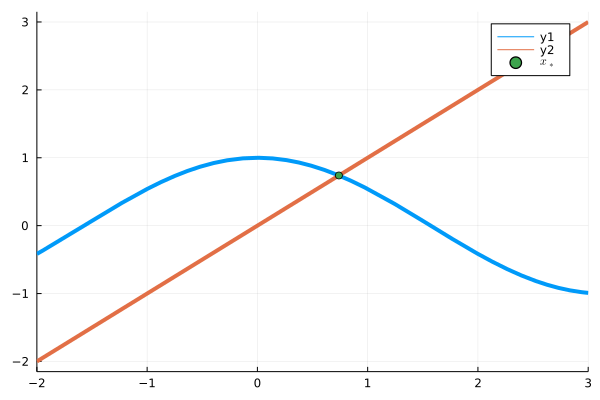

In [73]:
xstar, _ = newton(f, fp, 1.)
gprime = -sin(xstar)
@show xstar
@show gprime
plot([cos, x->x], xlims=(-2, 3))
scatter!([xstar], [xstar],
    label="\$x_*\$")

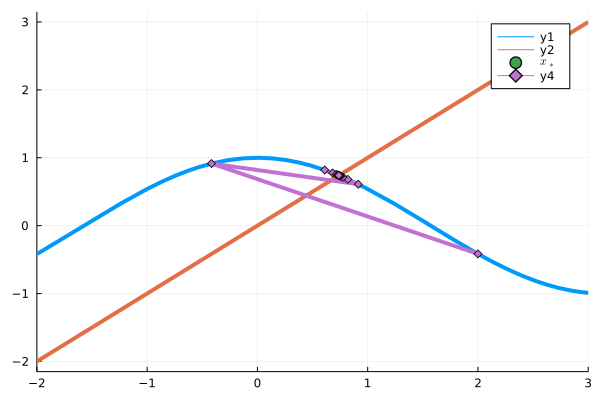

In [72]:
function fixed_point(g, x, n)
    xs = [x]
    for k in 1:n
        x = g(x)
        append!(xs, x)
    end
    xs
end

xs = fixed_point(cos, 2., 15)
plot!(xs, cos.(xs), seriestype=:path, marker=:auto)

# Verifying fixed point convergence theory


$$ \left\lvert \frac{e_{k+1}}{e_k} \right\rvert \to \lvert g'(x_*) \rvert $$

In [83]:
@show gprime
es = xs .- xstar
es[2:end] ./ es[1:end-1]

gprime = -0.6736120293089505


15-element Vector{Float64}:
 -0.9161855415615605
 -0.15197657010596488
 -0.734870205299266
 -0.624132525531327
 -0.7026257933893496
 -0.6523498121376077
 -0.6870971782336925
 -0.664168570025122
 -0.6798044680427148
 -0.6693659427636027
 -0.6764378047956165
 -0.6716930541785153
 -0.6748976495459512
 -0.6727427617641084
 -0.6741962236114177

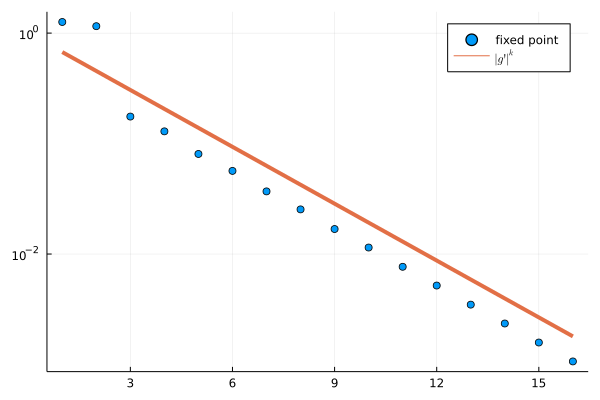

In [82]:
scatter(abs.(es), yscale=:log10, label="fixed point")
plot!(k -> abs(gprime)^k, label="\$|g'|^k\$")

# Plotting Newton convergence

In [ ]:
function newton_hist(f, fp, x0; tol=1e-12)
    x = x0
    hist = []
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        push!(hist, [x fx fpx])
        if abs(fx) < tol
            return vcat(hist...)
        end
        x = x - fx / fpx
    end
end

In [ ]:
h = newton_hist(f, fp, 1.97)
@show x_star = h[end,1]
plot(h[1:end-1,1] .- x_star, yscale=:log10, marker=:auto)

## Poll: Is this convergence A=q-linear, B=r-linear, C=neither?

# Formulations are not unique (constants)

If $x = g(x)$ then $x = g(x) + c(g(x) - x)$ for any constant $c$.

g2p(xstar) = -1.5104180439634258


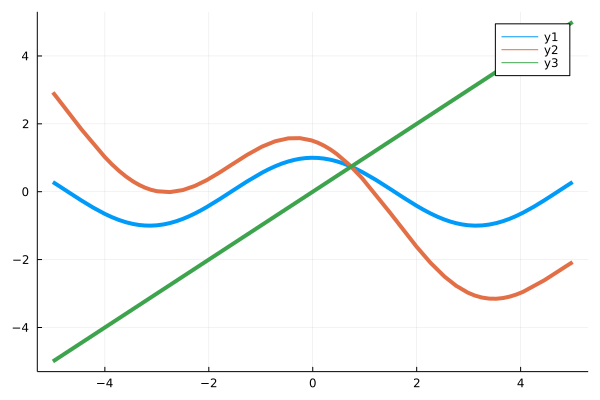

In [88]:
c = 0.5
g2(x) = cos(x) + c * (cos(x) - x)
g2p(x) = -sin(x) + c * (-sin(x) - 1)
@show g2p(xstar)
plot([cos,
      g2,
      x -> x])

In [89]:
xs = fixed_point(g2, 1., 15)
xs .- xstar

16-element Vector{Float64}:
  0.26091486661471597
 -0.4286316745830744
  0.533980847895856
 -0.9355913786055012
  0.8303000345072872
 -1.521660979680616
  0.7158522525828056
 -1.2931539564234353
  0.813535401918768
 -1.488133214912124
  0.7339450100692136
 -1.3291844363123972
  0.8022926581660198
 -1.4656525910895393
  0.7453871946625251
 -1.3519960573801981

# Formulations are not unique (functions)

If $x = g(x)$ then $x = x + \big(g(x) - x\big) h(x)$ for any $h(x) > c > 0$.

In [90]:
h(x) = 1 / (sin(x) + x)
g3(x) = x + (cos(x) - x) * h(x)

plot([cos,
      g3,
      x -> x])

LoadError: cannot define function h; it already has a value

# Next time

* Derivation via convergence theory
* Quadratic convergence!
* Culture: fast inverse square root
* Computing derivatives
* Reliability
* Globalization